In [ ]:
import os
import torch
import numpy as np
import re
import gc
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    logging as transformers_logging
)

In [ ]:
# 모델 경로 설정
model_path = "/content/drive/MyDrive/woke-odds/ambig_improve_v6"

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 특수 토큰 설정이 필요한 경우 확인
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# GPU 메모리 사용량 최적화
if torch.cuda.is_available():
    model = model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Custom Data Collator
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class DataCollatorForCausalLM:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        # input_ids의 최대 길이 찾기
        max_length = max(len(f["input_ids"]) for f in features)

        batch = {
            "input_ids": [],
            "attention_mask": [],
            "labels": []
        }

        for feature in features:
            input_ids = feature["input_ids"]
            attention_mask = feature["attention_mask"]
            labels = feature["labels"]

            # 패딩 길이 계산
            padding_length = max_length - len(input_ids)

            # 오른쪽에 패딩 추가
            padded_input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
            padded_attention_mask = attention_mask + [0] * padding_length
            padded_labels = labels + [-100] * padding_length  # -100은 loss 계산에서 무시됨

            batch["input_ids"].append(padded_input_ids)
            batch["attention_mask"].append(padded_attention_mask)
            batch["labels"].append(padded_labels)

        # 리스트를 텐서로 변환
        batch = {k: torch.tensor(v) for k, v in batch.items()}

        return batch

# Data Collator 생성
data_collator = DataCollatorForCausalLM(tokenizer=tokenizer)

In [ ]:
# 데이터 콜레이터 설정
#data_collator = DataCollatorForLanguageModeling(
#    tokenizer,
#    mlm=False,
#)

In [ ]:
#작업 경로 지정
import os
os.chdir('/content/drive/MyDrive/woke-odds')
print(os.getcwd())

/content/drive/MyDrive/woke-odds


In [ ]:
from datasets import load_dataset

# 데이터셋 로드
dataset = load_dataset('json', data_files={
    'train': 'ambiguity_train_1110.jsonl',
    'validation': 'ambiguity_valid_1110.jsonl',
    'test': 'ambiguity_test_1110.jsonl'
})

# 데이터 전처리
def preprocess_function(examples):
    # 'messages' 형식을 text로 변환 (Phi-4 chat template 적용)
    texts = []
    for messages in examples['messages']:
        # Phi-4의 chat template 사용
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(text)

    # 토크나이즈
    model_inputs = tokenizer(
        texts,
        max_length=768,
        truncation=True,
        padding=False  # DataCollator가 처리
    )

    # labels 설정 (CausalLM은 input_ids를 그대로 사용)
    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

모델 출력 확인 ⬇️


In [ ]:
import torch

# 테스트할 샘플 3개 선택
test_samples = [tokenized_dataset["test"][i] for i in range(3)]

print("=== 모델 출력 테스트 (3개 샘플) ===\n")

for idx, sample_data in enumerate(test_samples):
    # 원본 messages 가져오기 (토크나이즈 전 데이터에서)
    original_sample = dataset["test"][idx]
    messages = original_sample['messages']

    # system + user 메시지만 사용
    input_messages = [msg for msg in messages if msg['role'] != 'assistant']

    # Chat template 적용
    prompt = tokenizer.apply_chat_template(
        input_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # 토크나이즈
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # 디코딩 (입력 부분 제외)
    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    # 정답 추출
    ground_truth = [msg['content'] for msg in messages if msg['role'] == 'assistant'][0]
    user_query = [msg['content'] for msg in messages if msg['role'] == 'user'][0]

    # 출력
    print(f"[샘플 {idx+1}]")
    print(f"User Query: {user_query}")
    print(f"\nGround Truth: {ground_truth}")
    print(f"\nModel Output: {generated_text.strip()}")
    print("\n" + "="*80 + "\n")

=== 모델 출력 테스트 (3개 샘플) ===

[샘플 1]
User Query: Who plays the tiger in the jungle book 2016?

Ground Truth: NONE|NONE

Model Output: NONE|NONE


[샘플 2]
User Query: Most victories in ncaa division i men's college basketball?

Ground Truth: AO|WHAT

Model Output: AO|WHEN


[샘플 3]
User Query: Where did hurricane irma hit in the united states?

Ground Truth: NONE|NONE

Model Output: AO|WHEN




전체 평가 ⬇️


*   정확도
*   혼동 행렬 (대각선 요소가 진할 수록(예측=정답) 성능이 좋은 것)



In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["test"]

print(f"테스트 샘플 수: {len(eval_dataset)}")
print(f"첫 번째 샘플:\n{eval_dataset[0]}")

테스트 샘플 수: 321
첫 번째 샘플:
{'input_ids': [200022, 9719, 1308, 382, 102143, 11, 448, 20837, 13324, 8333, 9742, 656, 8321, 13, 1608, 553, 448, 20837, 2420, 484, 49842, 538, 290, 4928, 10860, 108041, 326, 744, 18573, 290, 154576, 364, 5927, 734, 16, 13, 57076, 538, 290, 4928, 10860, 108041, 25, 5364, 67114, 108041, 6118, 8, 503, 123648, 7, 13577, 3166, 6118, 446, 17, 13, 5646, 1985, 290, 154576, 734, 256, 533, 1843, 4928, 382, 5364, 11, 920, 8711, 28, 101023, 326, 84155, 28, 101023, 198, 256, 533, 1843, 4928, 382, 123648, 11, 92913, 8711, 326, 84155, 279, 6310, 6011, 25, 8711, 91, 3834, 1444, 279, 24858, 734, 12, 22363, 350, 72940, 51756, 291, 33404, 101164, 3127, 26639, 483, 85947, 26291, 503, 1051, 12, 8677, 324, 11649, 198, 12, 13120, 350, 43, 12432, 6207, 19143, 12143, 536, 3127, 26639, 483, 173846, 503, 86949, 154576, 198, 12, 77443, 350, 75635, 1246, 291, 18315, 3127, 26639, 483, 12486, 93741, 2164, 24297, 38441, 198, 12, 96381, 25, 22550, 5359, 484, 4128, 1841, 108041, 279, 3638, 17233

In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["test"]

def clarify_generation(messages, model, tokenizer, max_new_tokens=150):
    # system + user 메시지만 사용 (assistant 제외)
    input_messages = [msg for msg in messages if msg['role'] != 'assistant']

    # Chat template 적용
    prompt = tokenizer.apply_chat_template(
        input_messages,
        tokenize=False,
        add_generation_prompt=True  # assistant 응답 생성 프롬프트 추가
    )

    # 토크나이즈
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            output_scores=True,
            return_dict_in_generate=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # 생성된 토큰 ID 추출
    generated_ids = outputs.sequences[0][inputs['input_ids'].shape[1]:]

    # 디코딩 (입력 부분 제외)
    generated_text = tokenizer.decode(outputs.sequences[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    confidence = None
    if outputs.scores:
        token_probs = []
        for step_idx, step_logits in enumerate(outputs.scores):
            if step_idx >= len(generated_ids):
                break
            # 확률 계산
            step_probs = F.softmax(step_logits[0], dim=-1)
            # 실제 선택된 토큰의 확률
            token_id = generated_ids[step_idx].item()
            token_prob = step_probs[token_id].item()
            token_probs.append(token_prob)

        confidence = sum(token_probs) / len(token_probs) if token_probs else None

    return generated_text.strip(), confidence

In [ ]:
tokenizer.chat_template = """{% for message in messages %}{% if message['role'] == 'system' %}{{'<|system|>' + message['content'] + '<|end|>'}}{% elif message['role'] == 'user' %}{{'<|user|>' + message['content'] + '<|end|>'}}{% elif message['role'] == 'assistant' %}{{'<|assistant|>' + message['content'] + '<|end|>'}}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|assistant|>' }}{% endif %}"""

In [ ]:
#원본 데이터셋 사용
eval_dataset = dataset["test"]

# 전체 테스트 데이터셋에 대해 예측 수행
predictions = []
ground_truths = []
confidences = []

print("예측 시작...")
for example in tqdm(eval_dataset):
    messages = example['messages']

    # 모델 예측
    predicted, confidence = clarify_generation(messages, model, tokenizer)
    predictions.append(predicted)
    confidences.append(confidence)

    # 정답 (assistant의 응답)
    ground_truth = [msg['content'] for msg in messages if msg['role'] == 'assistant'][0]
    ground_truths.append(ground_truth)

print(f"예측 완료: {len(predictions)}개 샘플")

예측 시작...


100%|██████████| 321/321 [01:23<00:00,  3.83it/s]

예측 완료: 321개 샘플


In [ ]:
# 결과를 DataFrame으로 정리
results_df = pd.DataFrame({
    'user_query': [msg['content'] for example in eval_dataset for msg in example['messages'] if msg['role'] == 'user'],
    'ground_truth': ground_truths,
    'prediction': predictions,
    'confidence': confidences
})

# 처음 5개 결과 확인
print("=== 예측 결과 샘플 ===")
for idx in range(min(5, len(results_df))):
    print(f"\n[샘플 {idx+1}]")
    print(f"Query: {results_df.iloc[idx]['user_query']}")
    print(f"Ground Truth: {results_df.iloc[idx]['ground_truth']}")
    print(f"Prediction: {results_df.iloc[idx]['prediction']}")

=== 예측 결과 샘플 ===

[샘플 1]
Query: Who plays the tiger in the jungle book 2016?
Ground Truth: NONE|NONE
Prediction: NONE|NONE

[샘플 2]
Query: Most victories in ncaa division i men's college basketball?
Ground Truth: AO|WHAT
Prediction: AO|WHEN

[샘플 3]
Query: Where did hurricane irma hit in the united states?
Ground Truth: NONE|NONE
Prediction: NONE|NONE

[샘플 4]
Query: Kimberly told the aunt that the granddaughter respected her.
Who did the granddaughter respect?
Ground Truth: LA|SEM
Prediction: LA|SEM

[샘플 5]
Query: Matthew left a voicemail for Joshua because he wanted to share some updates.
Who wanted to share some updates?
Ground Truth: NONE|NONE
Prediction: NONE|NONE


In [ ]:
# 정확도 계산
results_df['is_correct'] = results_df['ground_truth'] == results_df['prediction']

accuracy = results_df['is_correct'].mean()
print(f"📊 전체 정확도: {accuracy*100:.2f}%")
print(f"   정답: {results_df['is_correct'].sum()}개")
print(f"   오답: {(~results_df['is_correct']).sum()}개")

📊 전체 정확도: 64.17%
   정답: 206개
   오답: 115개


In [ ]:
avg_confidence = results_df['confidence'].mean()
print(f"평균 신뢰도: {avg_confidence:.4f}")

평균 신뢰도: 0.9425


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 정답/오답별로 신뢰도 분리
correct_confidences = results_df[results_df['is_correct'] == True]['confidence'].dropna().tolist()
incorrect_confidences = results_df[results_df['is_correct'] == False]['confidence'].dropna().tolist()

# 기본 통계 계산
def calculate_statistics(data, label):
    if len(data) == 0:
        print(f"\n{label}: 데이터 없음")
        return None

    stats_dict = {
        '개수': len(data),
        '평균': np.mean(data),
        '중앙값': np.median(data),
        '표준편차': np.std(data),
        '최솟값': np.min(data),
        '최댓값': np.max(data),
        '25% 분위수': np.percentile(data, 25),
        '75% 분위수': np.percentile(data, 75),
    }

    return stats_dict

# 통계 출력
print("=" * 60)
print("신뢰도 통계 분석")
print("=" * 60)

print("\n[정답 예측 신뢰도 통계]")
correct_stats = calculate_statistics(correct_confidences, "정답")
if correct_stats:
    for key, value in correct_stats.items():
        if key == '개수':
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.6f}")

print("\n" + "-" * 60)

print("\n[오답 예측 신뢰도 통계]")
incorrect_stats = calculate_statistics(incorrect_confidences, "오답")
if incorrect_stats:
    for key, value in incorrect_stats.items():
        if key == '개수':
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.6f}")

신뢰도 통계 분석

[정답 예측 신뢰도 통계]
개수: 206
평균: 0.965885
중앙값: 1.000000
표준편차: 0.052735
최솟값: 0.762673
최댓값: 1.000000
25% 분위수: 0.948974
75% 분위수: 1.000000

------------------------------------------------------------

[오답 예측 신뢰도 통계]
개수: 115
평균: 0.900506
중앙값: 0.908905
표준편차: 0.068151
최솟값: 0.692410
최댓값: 1.000000
25% 분위수: 0.849870
75% 분위수: 0.955460


/tmp/ipython-input-1180756082.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True, showmeans=True)
/tmp/ipython-input-1180756082.py:11: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1180756082.py:11: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1180756082.py:11: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1180756082.py:11: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1180756082.py:11: UserWarning: Glyph 47280 (\N{HANGUL SYLLABLE ROE}) missing from font(s) DejaVu Sans.
  plt.tight_layout

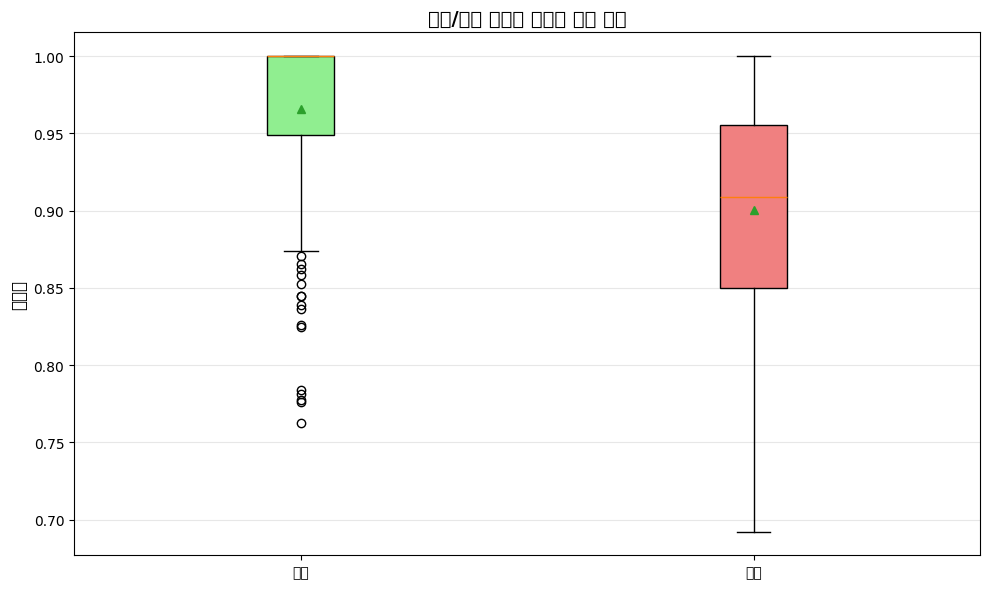

In [ ]:
# 박스플롯 시각화
plt.figure(figsize=(10, 6))
box_data = [correct_confidences, incorrect_confidences]
box_labels = ['정답', '오답']
bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
plt.ylabel('신뢰도', fontsize=12)
plt.title('정답/오답 예측의 신뢰도 분포 비교', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("=" * 60)
print("신뢰도 구간별 정확도 분석")
print("=" * 60)

confidence_bins = np.linspace(0, 1, 11)  # 0.0, 0.1, 0.2, ..., 1.0
bin_labels = [f"{confidence_bins[i]:.1f}-{confidence_bins[i+1]:.1f}"
              for i in range(len(confidence_bins)-1)]

# 각 구간별 정확도 계산
bin_accuracy = []
bin_counts = []

for i in range(len(confidence_bins)-1):
    lower = confidence_bins[i]
    upper = confidence_bins[i+1]

    # DataFrame에서 해당 구간에 속하는 샘플 필터링
    in_bin = results_df[
        (results_df['confidence'].notna()) &
        (results_df['confidence'] >= lower) &
        (results_df['confidence'] < upper)
    ]

    if len(in_bin) > 0:
        accuracy = in_bin['is_correct'].mean()
        bin_accuracy.append(accuracy)
        bin_counts.append(len(in_bin))
        print(f"신뢰도 {bin_labels[i]}: 정확도 {accuracy:.4f} ({len(in_bin)}개 샘플)")
    else:
        bin_accuracy.append(0)
        bin_counts.append(0)
        print(f"신뢰도 {bin_labels[i]}: 데이터 없음")

print("=" * 60 + "\n")


신뢰도 구간별 정확도 분석
신뢰도 0.0-0.1: 데이터 없음
신뢰도 0.1-0.2: 데이터 없음
신뢰도 0.2-0.3: 데이터 없음
신뢰도 0.3-0.4: 데이터 없음
신뢰도 0.4-0.5: 데이터 없음
신뢰도 0.5-0.6: 데이터 없음
신뢰도 0.6-0.7: 정확도 0.0000 (1개 샘플)
신뢰도 0.7-0.8: 정확도 0.3846 (13개 샘플)
신뢰도 0.8-0.9: 정확도 0.3175 (63개 샘플)
신뢰도 0.9-1.0: 정확도 0.5752 (113개 샘플)



클래스별 성능 측정 (데이터 불균형 훈련 이후 추가)

In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict, Counter

In [ ]:
results_df['true_category'] = results_df['ground_truth'].apply(lambda x: x.split('|')[0] if '|' in x else x)
results_df['true_subclass'] = results_df['ground_truth'].apply(lambda x: x.split('|')[1] if '|' in x and len(x.split('|')) > 1 else '')

results_df['pred_category'] = results_df['prediction'].apply(lambda x: x.split('|')[0] if '|' in x else x)
results_df['pred_subclass'] = results_df['prediction'].apply(lambda x: x.split('|')[1] if '|' in x and len(x.split('|')) > 1 else '')


Category 클래스 분포:
  AO: 80개 (24.9%)
  EM: 40개 (12.5%)
  LA: 40개 (12.5%)
  NONE: 161개 (50.2%)

Category 전체 정확도: 0.6947 (69.47%)

Category 클래스별 정확도:
  AO: 0.4625 (37/80)
  EM: 0.6000 (24/40)
  LA: 0.6500 (26/40)
  NONE: 0.8447 (136/161)

Category 혼동 행렬:
         예측 AO  예측 EM  예측 LA  예측 NONE
실제 AO       37      0      0       43
실제 EM        0     24      0       16
실제 LA        1      0     26       13
실제 NONE     15      4      6      136


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/us

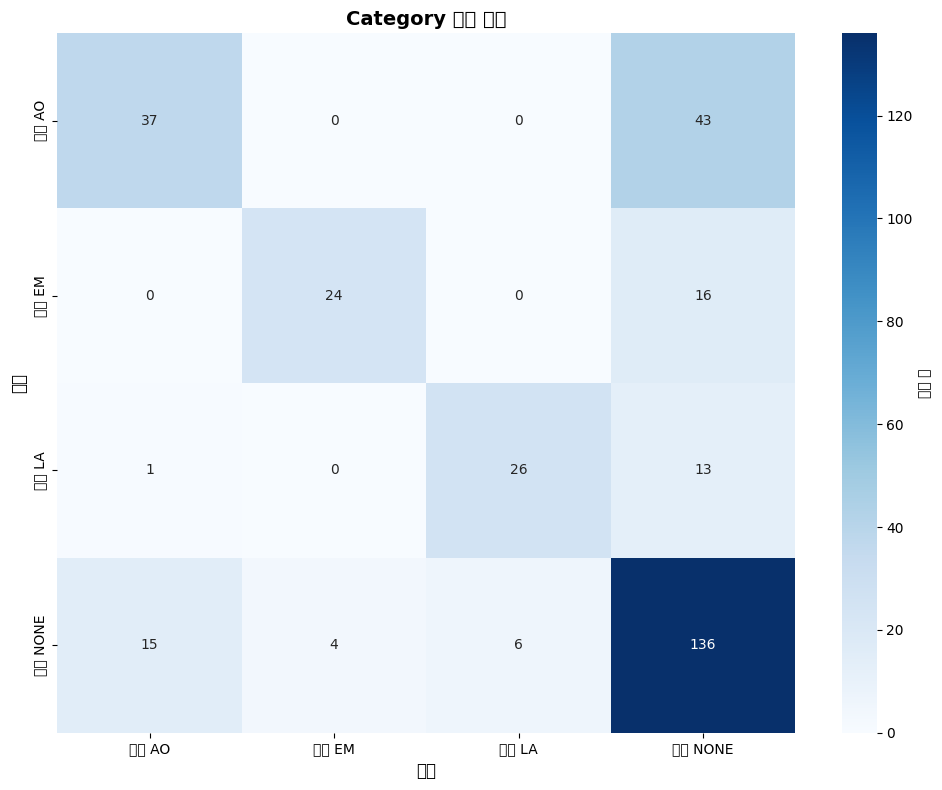

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# 클래스별 카운트
cat_counts = results_df['true_category'].value_counts().to_dict()
print("\nCategory 클래스 분포:")
for cls, count in sorted(cat_counts.items()):
    print(f"  {cls}: {count}개 ({count/len(results_df):.1%})")

# 정확도 계산
cat_accuracy = (results_df['true_category'] == results_df['pred_category']).mean()
print(f"\nCategory 전체 정확도: {cat_accuracy:.4f} ({cat_accuracy*100:.2f}%)")

# 클래스별 정확도
print("\nCategory 클래스별 정확도:")
for cls in sorted(results_df['true_category'].unique()):
    class_samples = results_df[results_df['true_category'] == cls]
    if len(class_samples) > 0:
        acc = (class_samples['true_category'] == class_samples['pred_category']).mean()
        correct_count = (class_samples['true_category'] == class_samples['pred_category']).sum()
        print(f"  {cls}: {acc:.4f} ({correct_count}/{len(class_samples)})")

# 혼동 행렬
cat_labels = sorted(results_df['true_category'].unique())
cat_cm = confusion_matrix(results_df['true_category'], results_df['pred_category'], labels=cat_labels)
cat_cm_df = pd.DataFrame(cat_cm, index=[f'실제 {l}' for l in cat_labels], columns=[f'예측 {l}' for l in cat_labels])

print("\nCategory 혼동 행렬:")
print(cat_cm_df)

# 정밀도, 재현율, F1 점수
cat_precision, cat_recall, cat_f1, cat_support = precision_recall_fscore_support(
    results_df['true_category'],
    results_df['pred_category'],
    labels=cat_labels,
    zero_division=0
)

# Category 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cat_cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': '샘플 수'})
plt.title('Category 혼동 행렬', fontsize=14, fontweight='bold')
plt.xlabel('예측', fontsize=12)
plt.ylabel('실제', fontsize=12)
plt.tight_layout()
plt.show()


Subclass 클래스 분포:
  CONT: 20개 (6.2%)
  LEX: 20개 (6.2%)
  NONE: 161개 (50.2%)
  SEM: 20개 (6.2%)
  UNF: 20개 (6.2%)
  WHAT: 20개 (6.2%)
  WHEN: 20개 (6.2%)
  WHERE: 20개 (6.2%)
  WHOM: 20개 (6.2%)

Subclass 전체 정확도: 0.6417 (64.17%)

Subclass 클래스별 정확도:
  CONT: 1.0000 (20/20)
  LEX: 0.6000 (12/20)
  NONE: 0.8447 (136/161)
  SEM: 0.7000 (14/20)
  UNF: 0.2000 (4/20)
  WHAT: 0.0500 (1/20)
  WHEN: 0.2000 (4/20)
  WHERE: 0.3500 (7/20)
  WHOM: 0.4000 (8/20)

Subclass 혼동 행렬 (상위 15개):
          예측 NONE  예측 WHOM  예측 SEM  예측 CONT  예측 WHERE  예측 LEX  예측 WHEN  \
실제 NONE       136        7       6        0         5       0        2   
실제 WHOM        12        8       0        0         0       0        0   
실제 SEM          6        0      14        0         0       0        0   
실제 CONT         0        0       0       20         0       0        0   
실제 WHERE        9        2       0        0         7       0        1   
실제 LEX          7        1       0        0         0      12        0   
실제 WHEN    

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/us

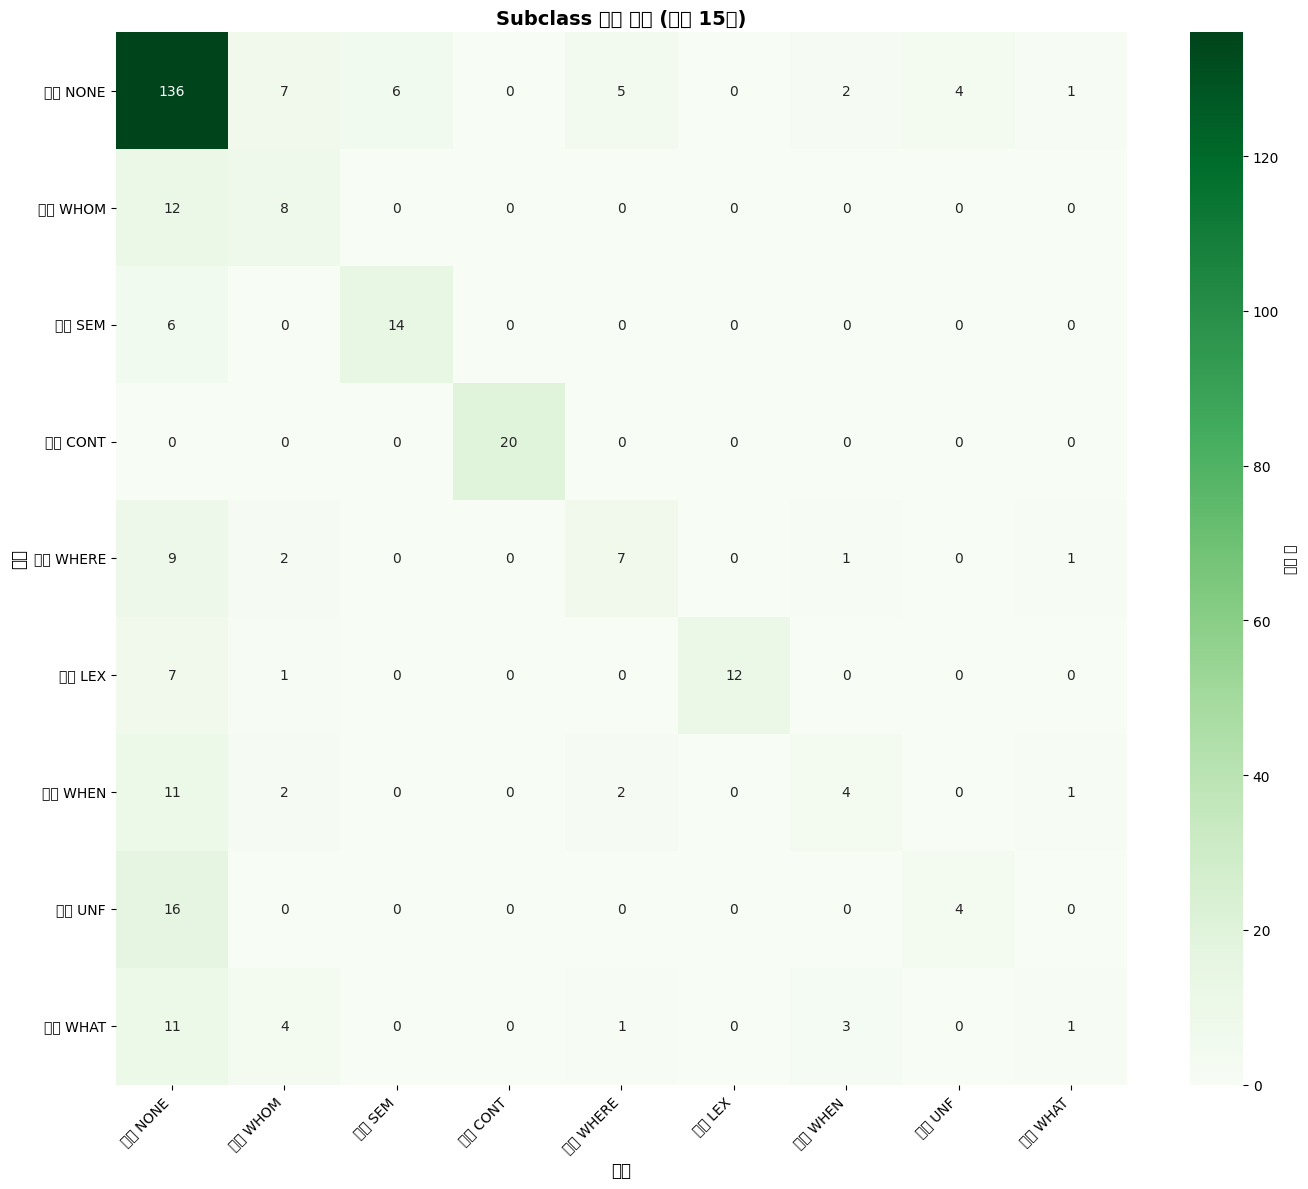

In [ ]:
# 빈 subclass 제외
subclass_df = results_df[results_df['true_subclass'] != ''].copy()

if len(subclass_df) > 0:
    # 클래스별 카운트
    sub_counts = subclass_df['true_subclass'].value_counts().to_dict()
    print("\nSubclass 클래스 분포:")
    for cls, count in sorted(sub_counts.items()):
        print(f"  {cls}: {count}개 ({count/len(subclass_df):.1%})")

    # 정확도 계산
    sub_accuracy = (subclass_df['true_subclass'] == subclass_df['pred_subclass']).mean()
    print(f"\nSubclass 전체 정확도: {sub_accuracy:.4f} ({sub_accuracy*100:.2f}%)")

    # 클래스별 정확도
    print("\nSubclass 클래스별 정확도:")
    for cls in sorted(subclass_df['true_subclass'].unique()):
        class_samples = subclass_df[subclass_df['true_subclass'] == cls]
        if len(class_samples) > 0:
            acc = (class_samples['true_subclass'] == class_samples['pred_subclass']).mean()
            correct_count = (class_samples['true_subclass'] == class_samples['pred_subclass']).sum()
            print(f"  {cls}: {acc:.4f} ({correct_count}/{len(class_samples)})")

    # 혼동 행렬 (상위 15개 클래스만)
    from collections import Counter
    sub_label_counts = Counter(subclass_df['true_subclass'].tolist() + subclass_df['pred_subclass'].tolist())
    top_15_sub_labels = [label for label, _ in sub_label_counts.most_common(15)]

    # 필터링
    filtered_sub_df = subclass_df[
        subclass_df['true_subclass'].isin(top_15_sub_labels) &
        subclass_df['pred_subclass'].isin(top_15_sub_labels)
    ]

    if len(filtered_sub_df) > 0:
        sub_cm = confusion_matrix(
            filtered_sub_df['true_subclass'],
            filtered_sub_df['pred_subclass'],
            labels=top_15_sub_labels
        )
        sub_cm_df = pd.DataFrame(
            sub_cm,
            index=[f'실제 {l}' for l in top_15_sub_labels],
            columns=[f'예측 {l}' for l in top_15_sub_labels]
        )

        print("\nSubclass 혼동 행렬 (상위 15개):")
        print(sub_cm_df)

        # 정밀도, 재현율, F1 점수
        sub_precision, sub_recall, sub_f1, sub_support = precision_recall_fscore_support(
            filtered_sub_df['true_subclass'],
            filtered_sub_df['pred_subclass'],
            labels=top_15_sub_labels,
            zero_division=0
        )

        print("\nSubclass 상세 지표 (상위 15개):")
        print(f"{'클래스':<10} {'정밀도':<10} {'재현율':<10} {'F1':<10} {'샘플수':<10}")
        print("-" * 50)
        for i, cls in enumerate(top_15_sub_labels):
            print(f"{cls:<10} {sub_precision[i]:<10.4f} {sub_recall[i]:<10.4f} {sub_f1[i]:<10.4f} {sub_support[i]:<10}")

        # Subclass 혼동 행렬 시각화
        plt.figure(figsize=(14, 12))
        sns.heatmap(sub_cm_df, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': '샘플 수'})
        plt.title('Subclass 혼동 행렬 (상위 15개)', fontsize=14, fontweight='bold')
        plt.xlabel('예측', fontsize=12)
        plt.ylabel('실제', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
else:
    print("Subclass 데이터가 없습니다.")

In [ ]:
from collections import defaultdict
import pandas as pd

# 결합 클래스 분석
combined_df = pd.DataFrame({
    'true': results_df['ground_truth'],
    'pred': results_df['prediction']
})

# 클래스별 카운트
combined_counts = combined_df['true'].value_counts()
print(f"총 고유 결합 클래스 수: {len(combined_counts)}")

# 전체 정확도
combined_accuracy = (combined_df['true'] == combined_df['pred']).mean()
print(f"\n결합 클래스 전체 정확도: {combined_accuracy:.4f} ({combined_accuracy*100:.2f}%)")

# 오분류 패턴 분석
print("\n주요 오분류 패턴:")
misclassifications = defaultdict(int)

for _, row in combined_df.iterrows():
    if row['true'] != row['pred']:
        pattern = f"{row['true']} -> {row['pred']}"
        misclassifications[pattern] += 1

if len(misclassifications) > 0:
    top_misclassifications = sorted(misclassifications.items(), key=lambda x: x[1], reverse=True)
    print(f"\n총 오분류 패턴 수: {len(misclassifications)}")
    print(f"총 오분류 횟수: {sum(misclassifications.values())}")

    print("\n상위 10개 오분류 패턴:")
    print(f"{'실제 → 예측':<30} {'횟수':<10} {'비율':<10}")
    print("-" * 50)
    total_errors = sum(misclassifications.values())
    for pattern, count in top_misclassifications[:10]:
        ratio = count / total_errors
        print(f"{pattern:<30} {count:<10} {ratio:<10.1%}")
else:
    print("오분류 없음! 완벽한 예측입니다.")

총 고유 결합 클래스 수: 9

결합 클래스 전체 정확도: 0.6417 (64.17%)

주요 오분류 패턴:

총 오분류 패턴 수: 23
총 오분류 횟수: 115

상위 10개 오분류 패턴:
실제 → 예측                        횟수         비율        
--------------------------------------------------
EM|UNF -> NONE|NONE            16         13.9%     
AO|WHOM -> NONE|NONE           12         10.4%     
AO|WHEN -> NONE|NONE           11         9.6%      
AO|WHAT -> NONE|NONE           11         9.6%      
AO|WHERE -> NONE|NONE          9          7.8%      
NONE|NONE -> AO|WHOM           7          6.1%      
LA|LEX -> NONE|NONE            7          6.1%      
LA|SEM -> NONE|NONE            6          5.2%      
NONE|NONE -> LA|SEM            6          5.2%      
NONE|NONE -> AO|WHERE          5          4.3%      
